# STAN47 Lab 6: Transfer Learning
* Instructors: [Małgorzata Bogdan](https://portal.research.lu.se/sv/persons/malgorzata-bogdan), [Hanqing Wu](https://portal.research.lu.se/en/persons/hanqing-wu) 

Transfer learning is a powerful technique in machine learning that allows us to leverage the knowledge gained from one task to improve performance on another. It’s very useful in the field of Computer Vision (CV), where training deep learning models from scratch requires large amounts of data and computational resources. In Keras, we can utilize pre-trained models such as VGG16, ResNet50, or EfficientNetB0 (**that we will use for today's lab**), which have been trained on large datasets like ImageNet. These models have already learned useful features from millions of images, and we can ‘transfer’ this learning to our specific task. This approach allows us to train high-performing models with less data and computational time.

In [47]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  ## To turn off debugging information 

import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import keras

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


We will again analyze the famous CIFAR-10 dataset. 

In [102]:
(cifar_x_train, cifar_y_train), (cifar_x_test, cifar_y_test) = tf.keras.datasets.cifar10.load_data()

In [49]:
origin_shape = cifar_x_train.shape
print(origin_shape)

(50000, 32, 32, 3)


Now, let us load the pre-trained `EfficientNetB0` model as the base model: 

In [50]:
input_shape_base_model=(128, 128, 3)

In [51]:
from keras.applications import EfficientNetB0
base_model = EfficientNetB0(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=input_shape_base_model,
    classes=10, # We only have 10 classes in CIFAR-10
    include_top=False # Do not include the ImageNet classifier at the top
)

In [52]:
# Freeze the earlier layers 
base_model.trainable=False

In [53]:
base_model.output_shape

(None, 4, 4, 1280)

In [54]:
base_model.input_shape

(None, 128, 128, 3)

In the above chunk of code, we remove the final classification layer of `EfficientNetB0`. In the following steps, we will replace it with a new layer(s) specific to our task. The earlier layers of the model serve as feature extractors, while the final layer(s) we add will classify the extracted features according to our specific task. We also freeze the earlier layers, meaning the weights (parameters) of these layers will not be updated during training.

### Task 1

The `EfficientNetB0` model was originally designed to analyze the ImageNet dataset, which consists of images with dimensions of 224x224x3. When applied to much smaller inputs, such as images from the CIFAR-10 dataset, `EfficientNetB0` may perform pooly. As a result, it becomes necessary to upscale the CIFAR-10 images. In the context of the above configuration, our goal is to upscale the images to a size of 128x128x3. (If you use 224x224x3, you will probably face some memory issues)

This can be achieved by incorporating a `keras.layers.Resizing` layer into the model. To visualize the impact of upscaling, select three images that you like from the CIFAR-10 training set. Generate a plot to compare each original image with its upscaled counterpart.

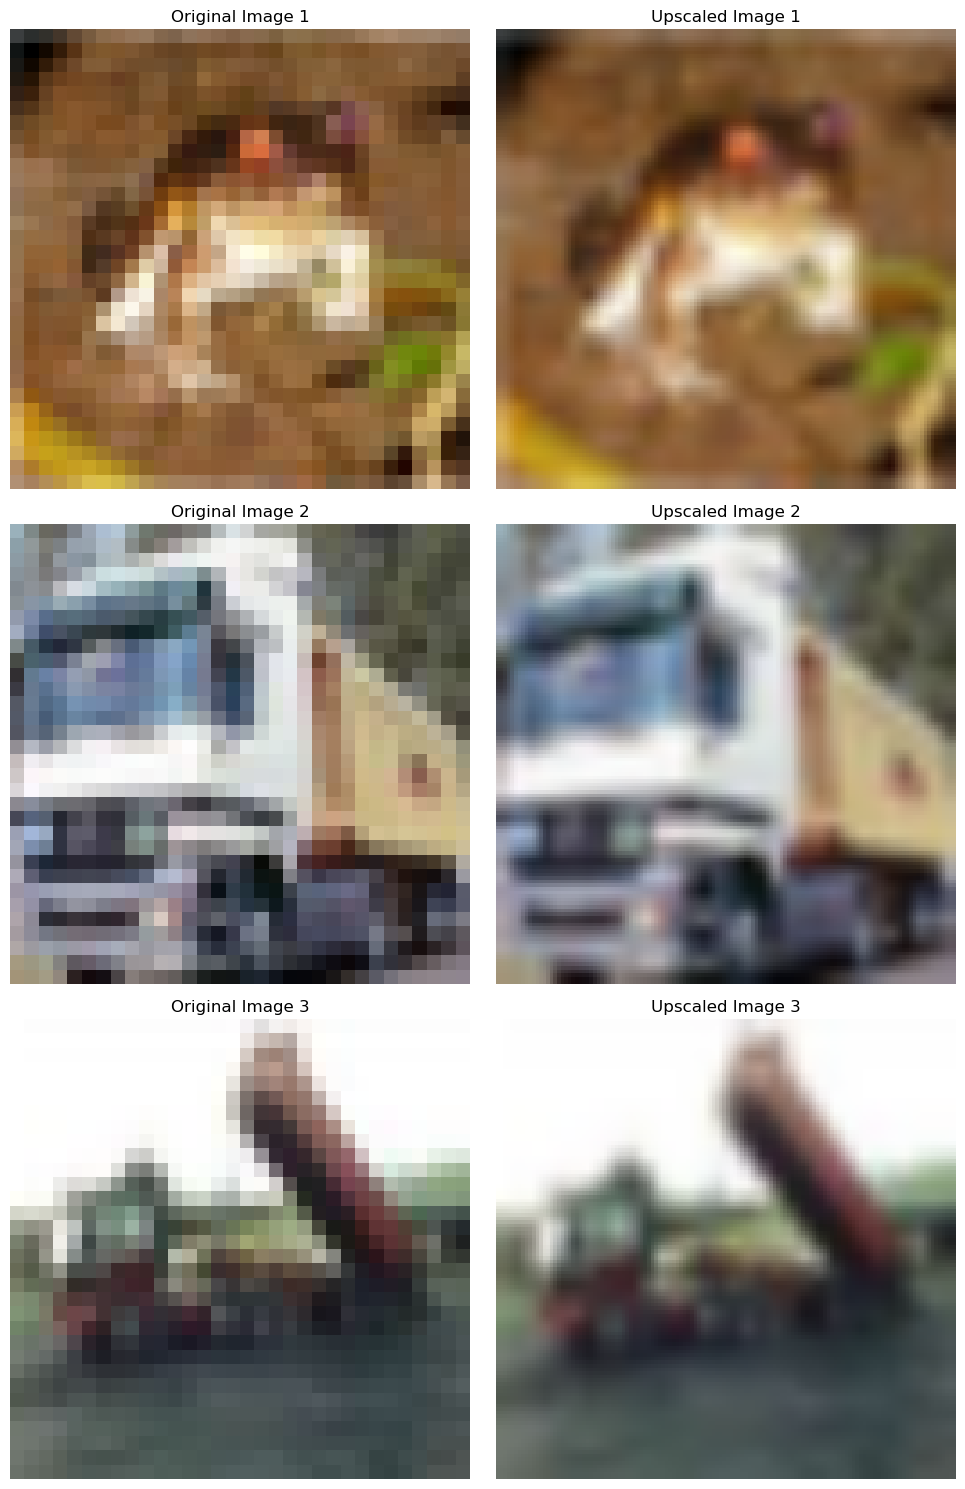

In [61]:
from tensorflow.keras import layers

# Load CIFAR-10 dataset
(cifar_x_train, cifar_y_train), (_, _) = tf.keras.datasets.cifar10.load_data()

# Resizing layer to upscale images to 128x128x3
resizing_layer = layers.Resizing(128, 128)

# Select three images from the training set
selected_images = cifar_x_train[:3]  # Selecting the first 3 images for simplicity

# Upscale the selected images
upscaled_images = resizing_layer(selected_images)

# Plotting original and upscaled images side by side
fig, axs = plt.subplots(3, 2, figsize=(10, 15))
for i in range(3):
    # Original images
    axs[i, 0].imshow(selected_images[i])
    axs[i, 0].set_title(f'Original Image {i+1}')
    axs[i, 0].axis('off')
    
    # Upscaled images
    axs[i, 1].imshow(upscaled_images[i].numpy().astype("uint8"))
    axs[i, 1].set_title(f'Upscaled Image {i+1}')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


---

With the help of the resizing layer, we are able to perform transfer learning with our `base_model`, which is `EfficientNetB0`.  Note that `EfficientNetB0` expects its inputs to be float tensors of pixels with values in the [0,255] range, so we **should not** rescale the pixels when employing `base_model`. It is important to make sure the input satisfies the specific requirement of the pre-trained model you plan to use.

### Task 2

Your task is to complete the code block below to construct `new_model` on top of the `base_model`. Feel free to add layers as you see fit.  Make sure that the `base_model` is running in inference mode here by passing `training=False`, so that the weights in our pre-trained model will not be affected.

In [62]:
input_shape = (32, 32, 3)

In [63]:
inputs = tf.keras.Input(shape=input_shape, name="inputs")

###### YOUR CODE BEGINS HERE ######
from tensorflow.keras import models

# Upscale images to the expected input size of EfficientNetB0
x = layers.Resizing(128, 128, interpolation="bilinear")(inputs)

# Pass the inputs through the base model (EfficientNetB0) in inference mode
x = base_model(x, training=False)

# Adding custom layers on top of the base model
# Flatten the output of the base model to a 1D vector
x = layers.Flatten()(x)

# Add a dense layer
x = layers.Dense(512, activation='relu')(x)

# Final output layer with softmax activation for classification
outputs = layers.Dense(10, activation='softmax')(x)
###### YOUR CODE ENDS HERE ######

new_model = tf.keras.Model(inputs, outputs)



We have now established `new_model` based on the pre-trained `EfficientNetB0`. It's time to train this model and assess its performance.

---

### Task 3

Train `new_model` on the training set using the same hyperparameters as you did for task 3 of lab 4, remembering to set `validation_split=0.2`. After the training is complete, evaluate `new_model`'s performance on the test set and compare its accuracy with the model you developed in task 4 of lab 3. Additionally, compare the number of trainable parameters in these two models. Based on these comparisons, provide your observations and comments.

In [104]:
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers, losses, metrics
from tensorflow.keras.utils import to_categorical
cifar_y_train_one_hot = to_categorical(cifar_y_train, num_classes=10)
cifar_y_test_one_hot = to_categorical(cifar_y_test, num_classes=10)


new_model.compile(optimizer='adam', # Deafult learning rate = 0.001
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [65]:
early_stopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-5)

In [68]:
cifar_y_train_corrected = cifar_y_train[:, 0,]  

In [35]:
history = new_model.fit(cifar_x_train, cifar_y_train_corrected,
                        batch_size=64,
                        epochs=100,  
                        validation_split=0.2,
                        callbacks=[early_stopper, reduce_lr])

Epoch 1/100
625/625 [==============================] - 161s 256ms/step - loss: 0.1167 - accuracy: 0.9706 - val_loss: 0.0560 - val_accuracy: 0.9798 - lr: 0.0010
Epoch 2/100
625/625 [==============================] - 153s 245ms/step - loss: 0.0293 - accuracy: 0.9891 - val_loss: 0.0604 - val_accuracy: 0.9801 - lr: 0.0010
Epoch 3/100
625/625 [==============================] - 155s 248ms/step - loss: 0.0125 - accuracy: 0.9955 - val_loss: 0.0728 - val_accuracy: 0.9804 - lr: 0.0010
Epoch 4/100
625/625 [==============================] - 167s 267ms/step - loss: 0.0136 - accuracy: 0.9955 - val_loss: 0.1013 - val_accuracy: 0.9779 - lr: 0.0010
Epoch 5/100
625/625 [==============================] - 171s 273ms/step - loss: 0.0121 - accuracy: 0.9962 - val_loss: 0.0926 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 6/100
625/625 [==============================] - ETA: 0s - loss: 0.0078 - accuracy: 0.9974
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
625/625 [=================

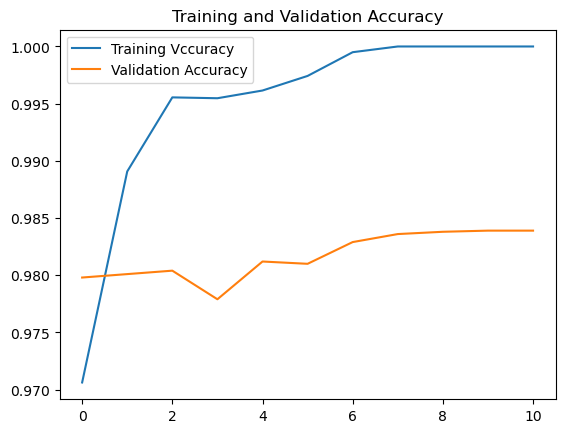

In [38]:
# Plot training and validation loss
plt.plot(history.history['accuracy'], label='Training Vccuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [105]:
test_loss, test_accuracy = new_model.evaluate(cifar_x_test, cifar_y_test_one_hot)

print(f'Test error: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

313/313 [==============================] - 37s 115ms/step - loss: 2.6676 - accuracy: 0.0903
Test error: 2.667585849761963
Test accuracy: 0.09030000120401382


However is the test accuracy really bad.

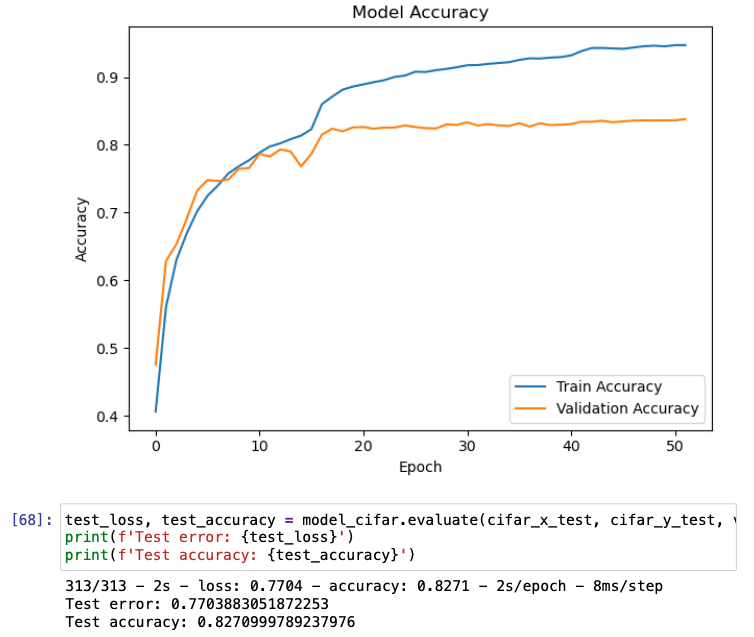

The new model (the first plot) preformce better then the model used in lab 4. The new model almost get a perfect validation accuracy and does that whith less epochs. The old model stoped after 50 epochs and the new model stoped after just 11.  

In [39]:
new_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 32, 32, 3)]       0         
                                                                 
 resizing_4 (Resizing)       (None, 128, 128, 3)       0         
                                                                 
 efficientnetb0 (Functional  (None, 4, 4, 1280)        4049571   
 )                                                               
                                                                 
 flatten_3 (Flatten)         (None, 20480)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               10486272  
                                                                 
 dense_7 (Dense)             (None, 10)                5130      
                                                           

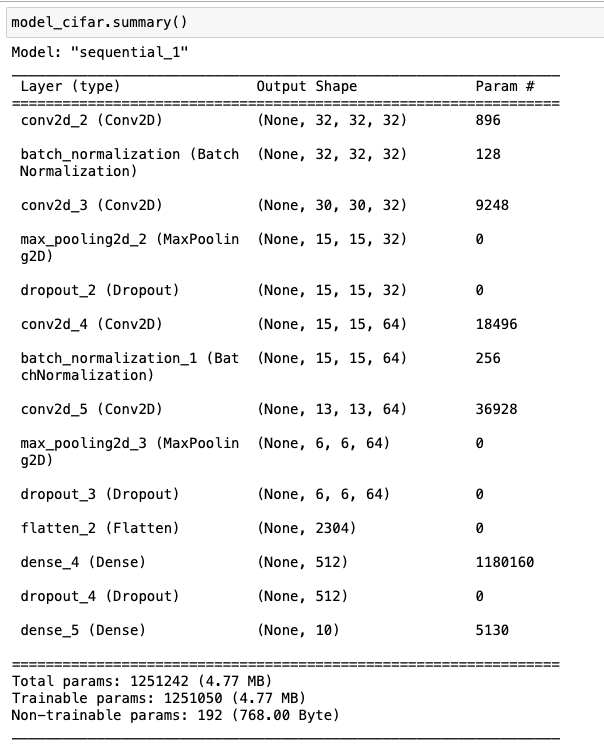

The new model has significantly more trainable parameters (10,491,402) compared to the old model (1,251,050). This increase in parameters means that the new model has a higher capacity to learn from data. With more parameters, the model can capture more complex features and relationships within the dataset, potentially leading to better generalization when predicting on new, unseen data.

A higher number of parameters often allows a neural network to create more intricate features and representations of the input data. This can be especially beneficial when dealing with complex datasets that require nuanced understanding to make accurate predictions.

Since the test accruacy for hte new model is significantly worse for the new model compared to the old there is a risk that the new model is overfitted.

---

### Fine-tuning

In this part, we will focus on fine-tuning `new_model` that we have established earlier. In the previous task, we only remove the top layer of `EfficientNetB0`. While fine-tuning involves unfreezing all or part of the layers of the pre-trained model and training it further on our CIFAR-10 classification task. This allows the model to adjust its more abstract representations to better suit our data. 

It’s important to note that fine-tuning should be done with **a lower learning rate** to avoid destroying the pre-trained weights. This process can lead to noteworthy improvements in model performance, as it tailors the model more closely to our specific task. Remember, **fine-tuning requires careful monitoring to prevent overfitting**.

### Task 4

Create two copies of `new_model` and name them `new_model_clone` and `new_model_clone2`. It's important to correctly set the weights for these two copies. In `new_model_clone`, unfreeze some of the layers from `EfficientNetB0` by setting `trainable = True`. Train both `new_model_clone` and `new_model_clone2` using a smaller learning rate and fewer epochs than you used in task 2. For instance, if you set the learning rate to `5e-4` and the number of epochs to 20 in task 2, you might adjust them to `5e-5` and 10, respectively, in this task. Keep all other hyperparameters the same as in task 2.

Once the training is complete, evaluate the performance of both `new_model_clone` and `new_model_clone2` on the test set. Compare the test accuracy of `new_model_clone` and `new_model_clone2`, and provide comments based on your findings.

In [115]:
new_model_clone = keras.models.clone_model(new_model)
new_model_clone.set_weights(new_model.get_weights())

new_model_clone2 = keras.models.clone_model(new_model)
new_model_clone2.set_weights(new_model.get_weights())

In [116]:
# Let's say you want to unfreeze the last 20 layers of the base model
N = 20

efficientnet_layer = new_model_clone.get_layer('efficientnetb0')

#unfreeze the EfficientNet layer itself
efficientnet_layer.trainable = True

# Unfreeze the last 20 layers of the EfficientNet layer
for layer in efficientnet_layer.layers[-N:]:
    layer.trainable = True



In [117]:
# Compile both models with a smaller learning rate
new_model_clone.compile(optimizer=keras.optimizers.legacy.Adam(5e-4),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

new_model_clone2.compile(optimizer=keras.optimizers.legacy.Adam(5e-4),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])


In [118]:
history_clone = new_model_clone.fit(cifar_x_train, cifar_y_train_one_hot,
                        batch_size=64,
                        epochs=10,  
                        validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 478s 761ms/step - loss: 0.3629 - accuracy: 0.8851 - val_loss: 0.3115 - val_accuracy: 0.8939
Epoch 2/10
625/625 [==============================] - 475s 759ms/step - loss: 0.1775 - accuracy: 0.9419 - val_loss: 0.2827 - val_accuracy: 0.9131
Epoch 3/10
625/625 [==============================] - 486s 778ms/step - loss: 0.1294 - accuracy: 0.9581 - val_loss: 0.2621 - val_accuracy: 0.9227
Epoch 4/10
625/625 [==============================] - 494s 790ms/step - loss: 0.1014 - accuracy: 0.9673 - val_loss: 0.2334 - val_accuracy: 0.9316
Epoch 5/10
625/625 [==============================] - 477s 764ms/step - loss: 0.0994 - accuracy: 0.9686 - val_loss: 0.2110 - val_accuracy: 0.9401
Epoch 6/10
625/625 [==============================] - 479s 767ms/step - loss: 0.0825 - accuracy: 0.9747 - val_loss: 0.3458 - val_accuracy: 0.9164
Epoch 7/10
625/625 [==============================] - 484s 775ms/step - loss: 0.0975 - accuracy: 0.9702 - val_loss: 0.2406 -

In [122]:
history_clone2 = new_model_clone2.fit(cifar_x_train, cifar_y_train_one_hot,
                        batch_size=64,
                        epochs=10,  
                        validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 162s 259ms/step - loss: 0.2276 - accuracy: 0.9265 - val_loss: 0.3225 - val_accuracy: 0.8941
Epoch 2/10
625/625 [==============================] - 165s 264ms/step - loss: 0.0603 - accuracy: 0.9796 - val_loss: 0.3573 - val_accuracy: 0.9010
Epoch 3/10
625/625 [==============================] - 149s 238ms/step - loss: 0.0192 - accuracy: 0.9949 - val_loss: 0.3996 - val_accuracy: 0.9049
Epoch 4/10
625/625 [==============================] - 149s 239ms/step - loss: 0.0261 - accuracy: 0.9917 - val_loss: 0.4900 - val_accuracy: 0.8989
Epoch 5/10
625/625 [==============================] - 149s 239ms/step - loss: 0.0320 - accuracy: 0.9893 - val_loss: 0.5509 - val_accuracy: 0.8933
Epoch 6/10
625/625 [==============================] - 149s 239ms/step - loss: 0.0513 - accuracy: 0.9847 - val_loss: 0.5558 - val_accuracy: 0.8953
Epoch 7/10
625/625 [==============================] - 150s 239ms/step - loss: 0.0284 - accuracy: 0.9913 - val_loss: 0.5885 -

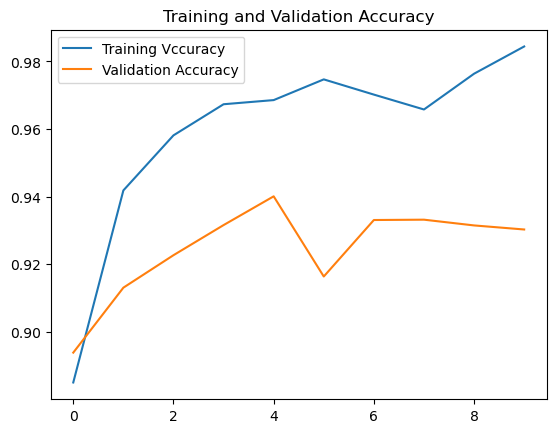

In [123]:
# Plot training and validation loss
plt.plot(history_clone.history['accuracy'], label='Training Vccuracy')
plt.plot(history_clone.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [121]:
test_loss_clone, test_accuracy_clone = new_model_clone.evaluate(cifar_x_test, cifar_y_test_one_hot)

print(f'Test error: {test_loss_clone}')
print(f'Test accuracy: {test_accuracy_clone}')

313/313 [==============================] - 39s 126ms/step - loss: 0.2795 - accuracy: 0.9263
Test error: 0.27950751781463623
Test accuracy: 0.9262999892234802


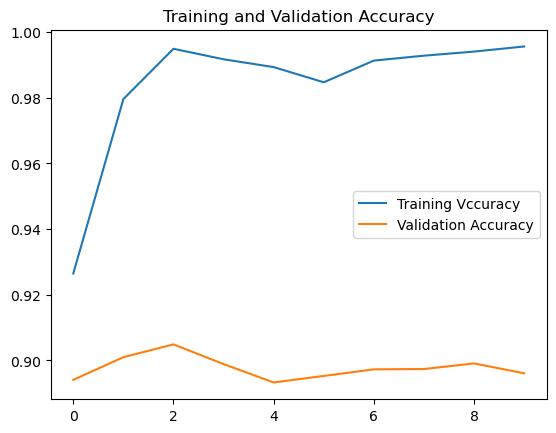

In [124]:
# Plot training and validation loss
plt.plot(history_clone2.history['accuracy'], label='Training Vccuracy')
plt.plot(history_clone2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [125]:
test_loss_clone2, test_accuracy_clone2 = new_model_clone2.evaluate(cifar_x_test, cifar_y_test_one_hot)

print(f'Test error: {test_loss_clone2}')
print(f'Test accuracy: {test_accuracy_clone2}')

313/313 [==============================] - 35s 113ms/step - loss: 0.7912 - accuracy: 0.8945
Test error: 0.7911788821220398
Test accuracy: 0.8945000171661377


The results seams to be the same is in the previously task, apart from the test accruacy. The test accruacy has increased a lot which could mean that the problem with overfiting the model had before is now gone. With a test accruacy around 92% for new_model_clone and 89% for new_model_clone2 indicates that the models preformes well on new unseen data points. 

So with more layers that are from the already trained nodel, my own model preformce better indicating that it is usful to use an already trained model as a base model. 

---

### Task 5

Select another pre-trained model that you find interesting and fine-tune it using the CIFAR-10 dataset. Plot the training and validation accuracy history, and report the test accuracy. You may choose from models provided by Keras Applications. Alternatively, for a more **challenging** and intriguing approach, consider fine-tuning models like ViT (Vision Transformer) from [the Huggingface Transformers library](https://huggingface.co/docs/transformers/model_doc/vit). Properly fine-tuning a pre-trained large model on an interesting dataset could even serve as a nice topic for the final project.

In [133]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load CIFAR-10 data
(cifar_x_train, cifar_y_train), (cifar_x_test, cifar_y_test) = cifar10.load_data()

# Normalize the data
cifar_x_train = cifar_x_train.astype('float32') / 255
cifar_x_test = cifar_x_test.astype('float32') / 255

# Convert class vectors to binary class matrices (one-hot encoding)
cifar_y_train_one_hot = to_categorical(cifar_y_train, 10)
cifar_y_test_one_hot = to_categorical(cifar_y_test, 10)

# Load ResNet50 pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(32, 32, 3)))

for layer in base_model.layers:
    layer.trainable = True

# Add custom layers on top for CIFAR-10 classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

# Define the final model
model_resnet50 = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_resnet50.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=5e-5), 
                       loss='categorical_crossentropy', 
                       metrics=['accuracy'])

# Model summary to confirm setup
model_resnet50.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_7[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 8, 8, 64)             16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 8, 8, 64)             256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 8, 8, 64)             0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 4, 4, 512)            66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 4, 4, 512)            2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 4, 4, 512)            0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 2, 2, 256)            590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 2, 2, 256)            1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 2, 2, 256)            0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 2, 2, 1024)           525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 2, 2, 1024)           0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 2, 2, 256)            262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 2, 2, 256)            1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 2, 2, 1024)           4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 2, 2, 1024)           0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 2, 2, 1024)           0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 1, 1, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 1, 1, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 1, 1, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 1, 1, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [134]:
history_resnet50 = model_resnet50.fit(cifar_x_train, cifar_y_train_one_hot,
                        batch_size=64,
                        epochs=10,  
                        validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 338s 538ms/step - loss: 1.4835 - accuracy: 0.4964 - val_loss: 4.5979 - val_accuracy: 0.1545
Epoch 2/10
625/625 [==============================] - 337s 539ms/step - loss: 0.8335 - accuracy: 0.7127 - val_loss: 0.9149 - val_accuracy: 0.6930
Epoch 3/10
625/625 [==============================] - 334s 534ms/step - loss: 0.5758 - accuracy: 0.8011 - val_loss: 0.8151 - val_accuracy: 0.7258
Epoch 4/10
625/625 [==============================] - 334s 535ms/step - loss: 0.3948 - accuracy: 0.8651 - val_loss: 0.8280 - val_accuracy: 0.7372
Epoch 5/10
625/625 [==============================] - 335s 537ms/step - loss: 0.2803 - accuracy: 0.9054 - val_loss: 0.8374 - val_accuracy: 0.7469
Epoch 6/10
625/625 [==============================] - 335s 536ms/step - loss: 0.2007 - accuracy: 0.9302 - val_loss: 0.8973 - val_accuracy: 0.7465
Epoch 7/10
625/625 [==============================] - 332s 532ms/step - loss: 0.1532 - accuracy: 0.9472 - val_loss: 0.9449 -

In [132]:
test_loss_resnet50, test_accuracy_resnet50 = model_resnet50.evaluate(cifar_x_test, cifar_y_test_one_hot)

print(f'Test error: {test_loss_resnet50}')
print(f'Test accuracy: {test_accuracy_resnet50}')

313/313 [==============================] - 13s 40ms/step - loss: 1.7933 - accuracy: 0.3639
Test error: 1.793306827545166
Test accuracy: 0.36390000581741333


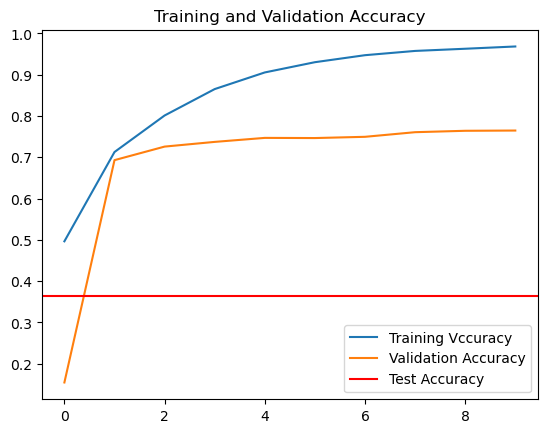

In [140]:
# Plot training and validation loss
plt.plot(history_resnet50.history['accuracy'], label='Training Vccuracy')
plt.plot(history_resnet50.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy_resnet50, color='r', linestyle='-', label=f'Test Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

The plot and shows the training, validation and test accuracy. Note that the test accuracy is not a part of the traing and is only a value but for the plots sake it is visualized as a line. Based on the test accuracy it's clear that the model has overfitted the data evan do i used a pre-trained model that was made based of the CIFAR-10 dataset. With complex architecture it is easier to make an overfitted model, and the pre-trained model used is very complex. Do deal with the problem it is better to not use ever layer in the pre-trained model.

---